# Demonstration of the Wavelet Block Coordinate Descent Algorithms

## Problem

In this demonstration, we showcase the Wavelet Block Coordinate Descent (WBCD) algorithms for solving inverse problems in imaging.

Let's assume we have a ground truth image $\bar x$ and we observe measurements $y$ obtained through a linear operator $A$ corrupted by additive Gaussian noise $\varepsilon$:
$$y = A \bar x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I).$$

We aim to solve the minimization problem:
$$\min_x \frac{1}{2} \|Ax - y\|_2^2 + \lambda \|W x\|_1,$$
where $W$ is a wavelet transform operator.

## Initalization

In [53]:
# Imports and Setup
import deepinv as dinv
import torch
import matplotlib.pyplot as plt

from utils.physics import BlurMatrix
from utils.convolution_matrix import create_gaussian_kernel_1d
from multilevel.block import BlockCoordinateDescent

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

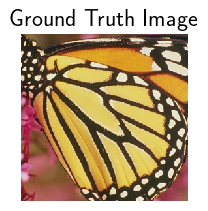

In [54]:
# Load ground truth image
x_true = dinv.utils.load_example('butterfly.png')
dinv.utils.plot(x_true, titles='Ground Truth Image')

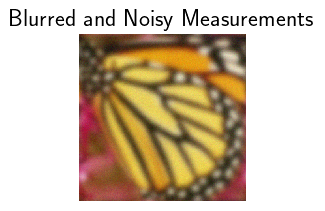

In [55]:
#--- Define the physical forward operator (e.g., a Gaussian blur) ---#

# Create 1D Gaussian blur kernels
filter_row = create_gaussian_kernel_1d(sigma=4.0, device=device, dtype=torch.float32)
filter_col = create_gaussian_kernel_1d(sigma=4.0, device=device, dtype=torch.float32)

# Define the blur operator using the created kernels
physics = BlurMatrix(filter_row, filter_col, padding="circular", device=device)

# Define noise model
physics.noise_model = dinv.physics.GaussianNoise(sigma=0.02)

# Generate measurements
y = physics(x_true)
dinv.utils.plot(y, titles='Blurred and Noisy Measurements')

## Reconstruction using Wavelet Block Coordinate Descent

In [56]:
# Define the objective function components
data_fidelity = dinv.optim.L2()

wv_type = 'haar'                # Type of wavelet
max_levels = 3                  # Number of wavelet decomposition levels
prior = dinv.optim.L1Prior()    # As by construction BCD solves the problem in the wavelet domain, we use L1 prior on wavelet coefficients

Anorm2 = physics.compute_norm(x_true).item()
stepsize = 1.0 / Anorm2         # Stepsize as 1/Lipschitz constant of the data fidelity term

# Initialize the Wavelet Block Coordinate Descent solver
bcd = BlockCoordinateDescent(x_true.shape, wv_type=wv_type, physics=physics, data_fidelity=data_fidelity, prior=prior, max_levels=max_levels, stepsize=stepsize, device=device)

Power iteration converged at iteration 24, ||A^T A||_2=0.98


/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/deepinv/physics/forward.py:575: DeprecationWarning: Using `compute_norm(squared=True)` is deprecated. Use `compute_sqnorm()` instead to compute the squared spectral norm (||A^T A||_2). In a future version, `compute_norm()` will compute the non-squared spectral norm (||A||_2) by default.
  warnings.warn(
/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn("Did not find Numba.")
/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn("Did not find Numba.")
/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn

In [57]:
# Run algorithm
n_iter = 100
n_iter_coarse = 1 # Number of iterations on each block
reg_weight = 1e-3   # Regularization parameter

# Choose the update rule: 'FB', 'cyclic', 'MLFB' or 'MLFBdetails'
update_mode = 'cyclic'

x0 = y.clone()  # Initial point
x_rec, loss, times, cycles, psnr = bcd.run(y, x0, x_true=x_true, n_iter=n_iter, n_iter_coarse=n_iter_coarse, reg_weight=reg_weight, update_mode=update_mode, metrics=True)

/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn("Did not find Numba.")
/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn("Did not find Numba.")


Number of gradient matrices: 200


/home/edgar/Documents/Git repositories/WaveletBlockCoordinateDescent/.venv/lib/python3.12/site-packages/lazylinop/signal/dwt.py:128: UserWarning: Did not find Numba.
  warnings.warn("Did not find Numba.")
BCD cyclic: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s, loss=43.08]


## Display results

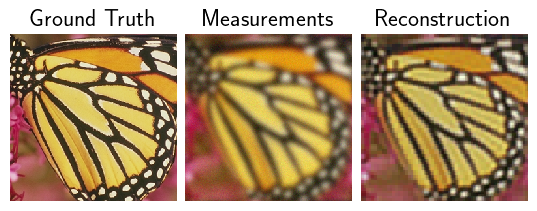

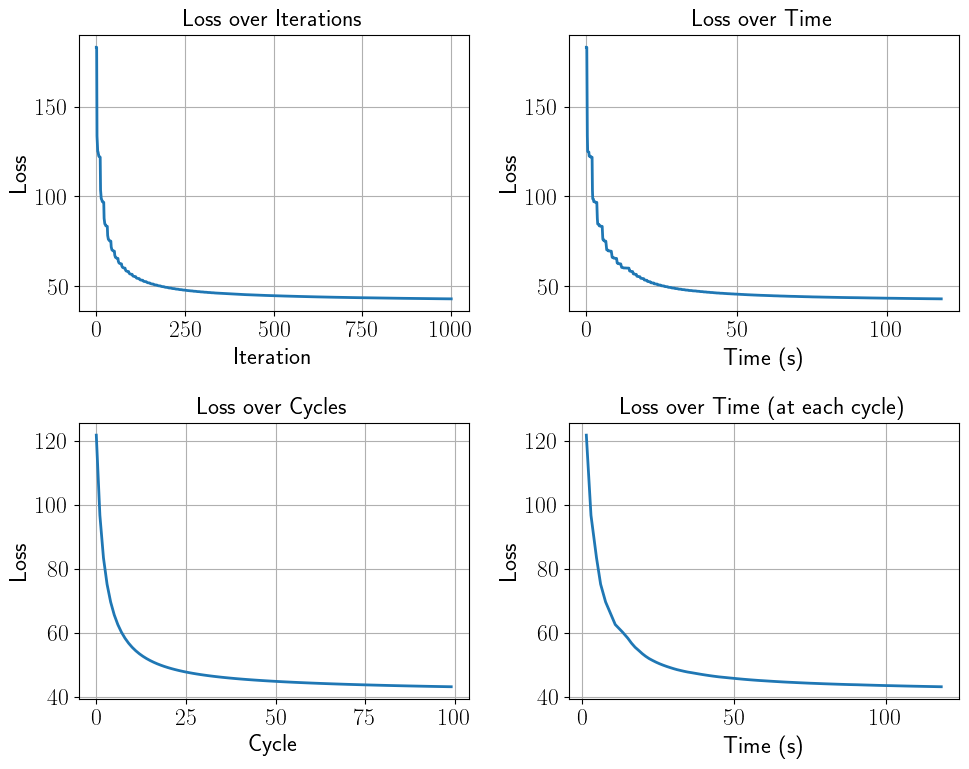

In [58]:
# Reconstruction
dinv.utils.plot([x_true, y, x_rec], titles=['Ground Truth', 'Measurements', 'Reconstruction'])

# Loss plot
loss_cycles = [loss[i] for i in cycles]
time_cycles = [times[i] for i in cycles]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. Loss over iterations
axes[0, 0].plot(loss)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss over Iterations')
axes[0, 0].grid()

# 2. Loss over time
axes[0, 1].plot(times, loss)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss over Time')
axes[0, 1].grid()

# 3. Loss over cycles
axes[1, 0].plot(loss_cycles)
axes[1, 0].set_xlabel('Cycle')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Loss over Cycles')
axes[1, 0].grid()

# 4. Loss over time at each cycle
axes[1, 1].plot(time_cycles, loss_cycles)
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Loss over Time (at each cycle)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()